In [146]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb 
import lightgbm as lgb 

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


In [147]:
#pip install opendatasets

In [148]:
df=pd.read_csv('data/train.csv')


In [149]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [151]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [152]:
df['Sales'].describe()

count     9800.000000
mean       230.769059
std        626.651875
min          0.444000
25%         17.248000
50%         54.490000
75%        210.605000
max      22638.480000
Name: Sales, dtype: float64

In [153]:
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

## Visualizations

----------------------------------


Text(0, 0.5, 'Total Sales')

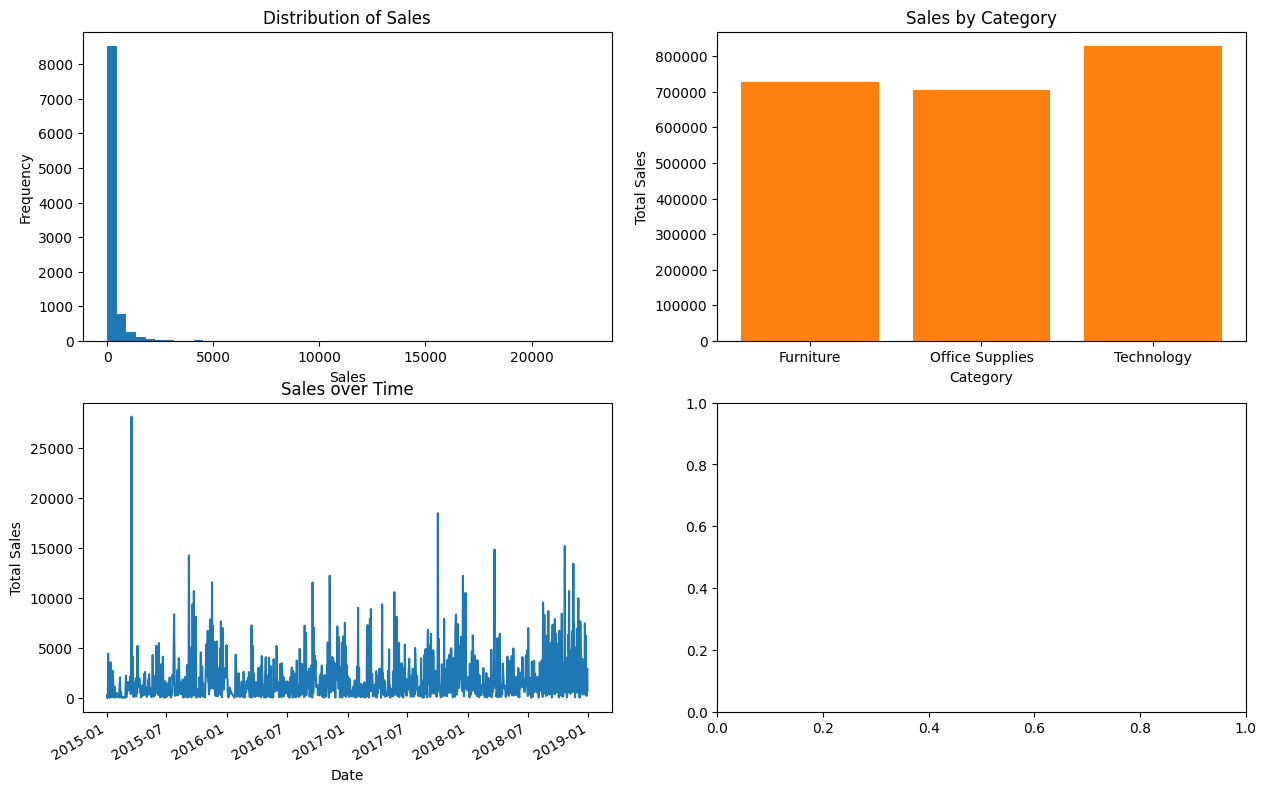

In [154]:
fig,axes=plt.subplots(2,2,figsize=(15,10))

# 1. Distribution of sales
axes[0,0].hist(df['Sales'],bins=50)
axes[0,0].set_title('Distribution of Sales')

axes[0,0].set_xlabel('Sales')
axes[0,0].set_ylabel('Frequency')

# 2.Sales by category
category_sales=df.groupby('Category')['Sales'].sum()
axes[0,1].bar(category_sales.index,category_sales.values)
axes[0,1].bar(category_sales.index,category_sales.values)
axes[0,1].set_title('Sales by Category')
axes[0,1].set_xlabel('Category')
axes[0,1].set_ylabel('Total Sales')
print('----------------------------------')

# 3.Sales over time
df_temp=df.copy()
df_temp['Order Date']=pd.to_datetime(df_temp['Order Date'],format='%d/%m/%Y')
df_temp.set_index('Order Date',inplace=True)
df_temp.groupby('Order Date')['Sales'].sum().plot(ax=axes[1,0])
axes[1,0].set_title('Sales over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Total Sales')





## Preprocessing

In [155]:
df_clean=df.copy()
df_clean

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [156]:
# Handling missing values
initial_rows=len(df_clean)
initial_rows
print(f"Rows after removing the missing values: {len(df_clean)}")
df_clean=df_clean.dropna(subset=['Sales','Order Date'])
print(f"Rows removed: {initial_rows-len(df_clean)} ")
# df_clean

Rows after removing the missing values: 9800
Rows removed: 0 


In [157]:
#Conver the date columns to dateTime
df_clean['Order Date']=pd.to_datetime(df_clean['Order Date'],format='%d/%m/%Y')
df_clean['Ship Date']=pd.to_datetime(df_clean['Ship Date'],format='%d/%m/%Y')

print(f"Date range: {df_clean['Order Date'].min()} to {df_clean['Order Date'].max()}")

Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00


In [158]:
# Remove outliers using IQR Method

"""
df.quantile(0.25)=q1
df.quantile(0.5)=q2
df.quantile(0.75)=q3
"""

Q1=df_clean['Sales'].quantile(0.25)
Q3=df_clean['Sales'].quantile(0.75)

IQR=Q3-Q1

lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

df_clean=df_clean[(df_clean['Sales']>=lower_bound)&(df_clean['Sales']<=upper_bound)]


## Feature Engineering

In [159]:
"""
Delivery Duration
"""

#Datetime features
df_clean['Year']=df_clean['Order Date'].dt.year
df_clean['Month']=df_clean['Order Date'].dt.month
df_clean['Day']=df_clean['Order Date'].dt.day
df_clean['Day Of Week']=df_clean['Order Date'].dt.dayofweek
df_clean['Delivery Duration']=(df_clean['Ship Date']-df_clean['Order Date']).dt.days
df_clean['Quarter']=df_clean['Order Date'].dt.quarter
df_clean['WeekOfYear']=df_clean['Order Date'].dt.isocalendar().week.astype(int)
df_clean['IsWeekend']=df_clean['Day Of Week'].isin([5,6]).astype(int)


#Create cyclical encoding for temporal features
df_clean['Month_Sin']=np.sin(2*np.pi*df_clean['Month']/12)
df_clean["Month_Cos"]=np.cos(2*np.pi*df_clean['Month']/12)
df_clean['Day_Sin']=np.sin(2*np.pi*df_clean['Day']/12)
df_clean['Day_Cos']=np.cos(2*np.pi*df_clean['Day']/12)


# Sort by 'Order Date' to ensure correct time series operation
df_clean=df_clean.sort_values(by='Order Date').reset_index(drop=True)

# Lag Features
for lag in [1,7,14,30]:
    # Apply shift directly on the sales column after sorting
    df_clean[f'Sales_Lag_{lag}']=df_clean['Sales'].shift(lag)

#Rolling stats
for window in [7,14,30,90]:
    #Apply Rolling directly on the Sales column after sorting
    df_clean[f'Sales_Rolling_Mean_{window}']=df_clean['Sales'].rolling(window=window).mean()
    df_clean[f'Sales_Rolling_Std_{window}']=df_clean['Sales'].rolling(window=window).std()

In [160]:
df_clean

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales_Lag_14,Sales_Lag_30,Sales_Rolling_Mean_7,Sales_Rolling_Std_7,Sales_Rolling_Mean_14,Sales_Rolling_Std_14,Sales_Rolling_Mean_30,Sales_Rolling_Std_30,Sales_Rolling_Mean_90,Sales_Rolling_Std_90
0,7981,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,742,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1760,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,1297,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,7.968,78.8528,185.702286,118.366127,152.547429,139.122349,98.501933,123.269815,98.984287,118.467471
8651,5092,CA-2018-156720,2018-12-30,2019-01-03,Standard Class,JM-15580,Jill Matthias,Consumer,United States,Loveland,...,34.580,27.1680,156.177143,135.865477,150.293429,141.417325,97.697133,123.829144,98.760909,118.630951
8652,1298,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,12.530,7.4000,115.940571,126.753190,150.878429,140.819278,98.141133,123.517699,98.470420,118.791358
8653,909,CA-2018-143259,2018-12-30,2019-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,...,19.600,2.4800,109.034286,128.992548,153.248143,138.703430,99.817667,122.511739,98.766153,118.642354


In [161]:
df_clean.isnull().sum()

Row ID                    0
Order ID                  0
Order Date                0
Ship Date                 0
Ship Mode                 0
Customer ID               0
Customer Name             0
Segment                   0
Country                   0
City                      0
State                     0
Postal Code               6
Region                    0
Product ID                0
Category                  0
Sub-Category              0
Product Name              0
Sales                     0
Year                      0
Month                     0
Day                       0
Day Of Week               0
Delivery Duration         0
Quarter                   0
WeekOfYear                0
IsWeekend                 0
Month_Sin                 0
Month_Cos                 0
Day_Sin                   0
Day_Cos                   0
Sales_Lag_1               1
Sales_Lag_7               7
Sales_Lag_14             14
Sales_Lag_30             30
Sales_Rolling_Mean_7      6
Sales_Rolling_Std_7 

In [162]:
# Encode categorical variables
CATEGORICAL_COLS=[ 'Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
NUMERICAL_COLS=['Sales']


In [163]:
for col in CATEGORICAL_COLS:
    le=LabelEncoder()
    df_clean[f'{col}_Encoded']=le.fit_transform(df_clean[col])

In [164]:
df_clean

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales_Rolling_Mean_90,Sales_Rolling_Std_90,Ship Mode_Encoded,Segment_Encoded,Country_Encoded,City_Encoded,State_Encoded,Region_Encoded,Category_Encoded,Sub-Category_Encoded
0,7981,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,NaN,NaN,3,0,0,206,41,0,1,12
1,740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,3,2,0,316,11,0,1,10
2,741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,3,2,0,316,11,0,1,14
3,742,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,NaN,NaN,3,2,0,316,11,0,1,3
4,1760,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,NaN,NaN,3,0,0,369,36,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8650,1297,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,98.984287,118.467471,3,1,0,146,3,3,1,3
8651,5092,CA-2018-156720,2018-12-30,2019-01-03,Standard Class,JM-15580,Jill Matthias,Consumer,United States,Loveland,...,98.760909,118.630951,3,0,0,264,4,3,1,8
8652,1298,CA-2018-115427,2018-12-30,2019-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,Fairfield,...,98.470420,118.791358,3,1,0,146,3,3,1,3
8653,909,CA-2018-143259,2018-12-30,2019-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,New York City,...,98.766153,118.642354,3,0,0,324,30,1,1,3


## Time Series Decomposition

In [165]:
# Aggregate to daily sales

daily_sales=df_clean.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales=daily_sales.set_index('Order Date')
daily_sales

,Sales
Order Date,
2015-01-03,16.4480
2015-01-04,288.0600
2015-01-05,19.5360
2015-01-06,467.3400
2015-01-07,87.1580
...,...
2018-12-26,63.9140
2018-12-27,177.6360
2018-12-28,931.5108


In [166]:
# Test of stationary ADF Test (Augumented Dicky Fuller Test)
adf_result=adfuller(daily_sales['Sales'].dropna())

print((f"ADF Statistics: {adf_result[0]}"))
print(f"p-value: {adf_result[1]}")
print(f"Statinary: {'Yes' if adf_result[1]<0.5 else 'No'}")

ADF Statistics: -5.142619304696873
p-value: 1.150101025057895e-05
Statinary: Yes


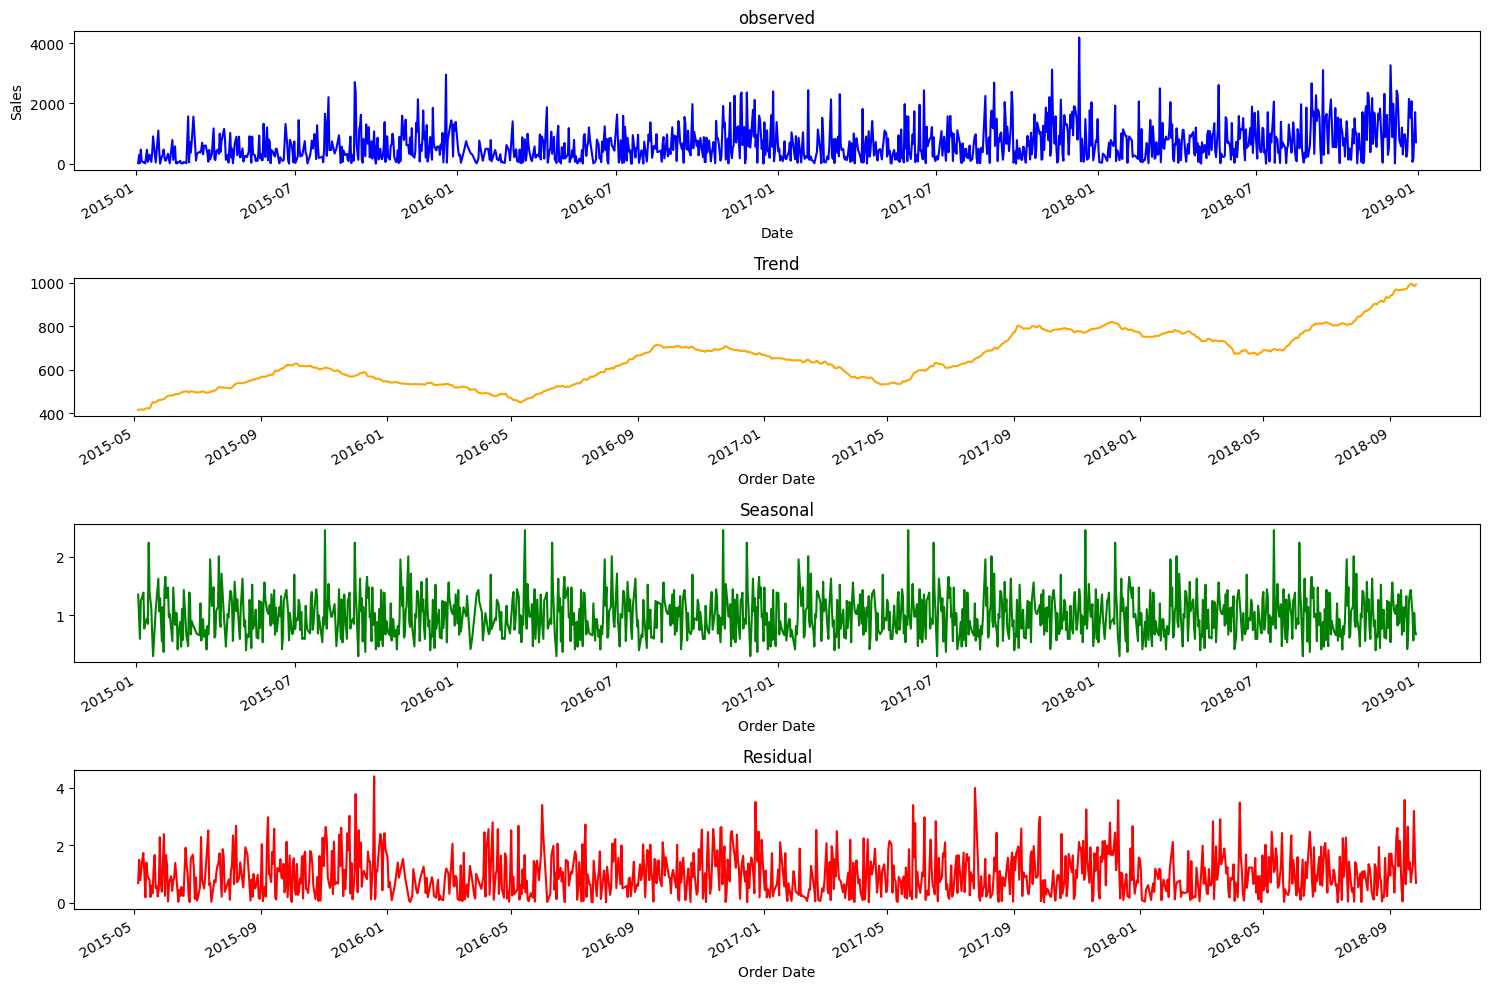

In [167]:
# Decomposition
decomposition=seasonal_decompose(daily_sales['Sales'],model='multiplicative',period=180)

# Decomposition Plot
fig,axes=plt.subplots(4,1,figsize=(15,10))

decomposition.observed.plot(ax=axes[0],color='blue')
axes[0].set_title('observed')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

decomposition.trend.plot(ax=axes[1],color='orange')
axes[1].set_title('Trend')

decomposition.seasonal.plot(ax=axes[2],color='green')
axes[2].set_title('Seasonal')

decomposition.resid.plot(ax=axes[3],color='red')
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

## Modeling

In [168]:
# Perpare feature and target

encoded_cats=[f'{col}_Encoded' for col in CATEGORICAL_COLS]
time_features=['Year','Month','Day','Delivery Duration','Quarter','WeekOfYear','IsWeekend','Month_Sin','Month_Cos','Day_Sin','Day_Cos']
lag_features=[col for col in df_clean.columns if 'Lag']

FEATURE_COLS=encoded_cats+time_features+lag_features
TARGET_COL='Sales'

X=df_clean[FEATURE_COLS]
y=df_clean[TARGET_COL]
#X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=12

split_idx=int(len(X)*0.8)
X_train,X_test=X.iloc[:split_idx],X.iloc[split_idx:]
y_train,y_test=y.iloc[:split_idx],y.iloc[split_idx:]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")



Train size: 6924
Test size: 1731


In [169]:
# Scaler features
num_cols=X_train.select_dtypes(include=['int64','float64']).columns

scaler=StandardScaler()
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()


X_train_scaled[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols]=scaler.transform(X_test[num_cols])

## Initialize models

In [170]:
models={
    'Linear Regression':LinearRegression(),
    'Random Forest':RandomForestRegressor(),
    'Gradient Boosting':GradientBoostingRegressor(),
    'XGBoost':xgb.XGBRegressor(),
    'LightGBM':lgb.LGBMRegressor()
}

In [171]:
# Train and evaluate models

results={}

predictions_dict={}

for model_name,model in models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_scaled,y_train)

    y_pred=model.predict(X_test_scaled)

    mse=mean_squared_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    mape=np.mean(np.abs((y_test-y_pred)/y_test))*100

Training Linear Regression...


ValueError: could not convert string to float: 'CA-2015-103800'